# ARIMA Models:

##### ARIMA stands for AutoRegressive Integrated Moving Average. 
ARIMA models use a combination of multiple regression on the past values and moving averages of the past residuals to generate forecasts

##### The ARIMA models have 3 important components called the order of the model;
* p: which is the order of the autoregressive part and designates the number of past observations to take into account
* d: which is the order of differencing that is applied to the data
* q: which is the order of the moving average part and designates the number of past residuals to take into account

components for generating forecasts. These components and their calculations vary based on the method used.

In [1]:
#Import pandas for loading a time series dataframe and matplotlib for some plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the Monthly Temperatures Data
#https://datahub.io/core/global-temp#data
df = pd.read_csv("/home/hasan/Desktop/Codes/yzt_main/datasets/monthly_temp.csv", index_col=0)
df

,GCAG Mean Temp,GISTEMP Mean Temp
2016-12-06,0.7895,0.81
2016-11-06,0.7504,0.93
2016-10-06,0.7292,0.89
2016-09-06,0.8767,0.87
2016-08-06,0.8998,0.98
...,...,...
1880-05-06,-0.0738,-0.14
1880-04-06,-0.0499,-0.27
1880-03-06,-0.1357,-0.18
1880-02-06,-0.1229,-0.21


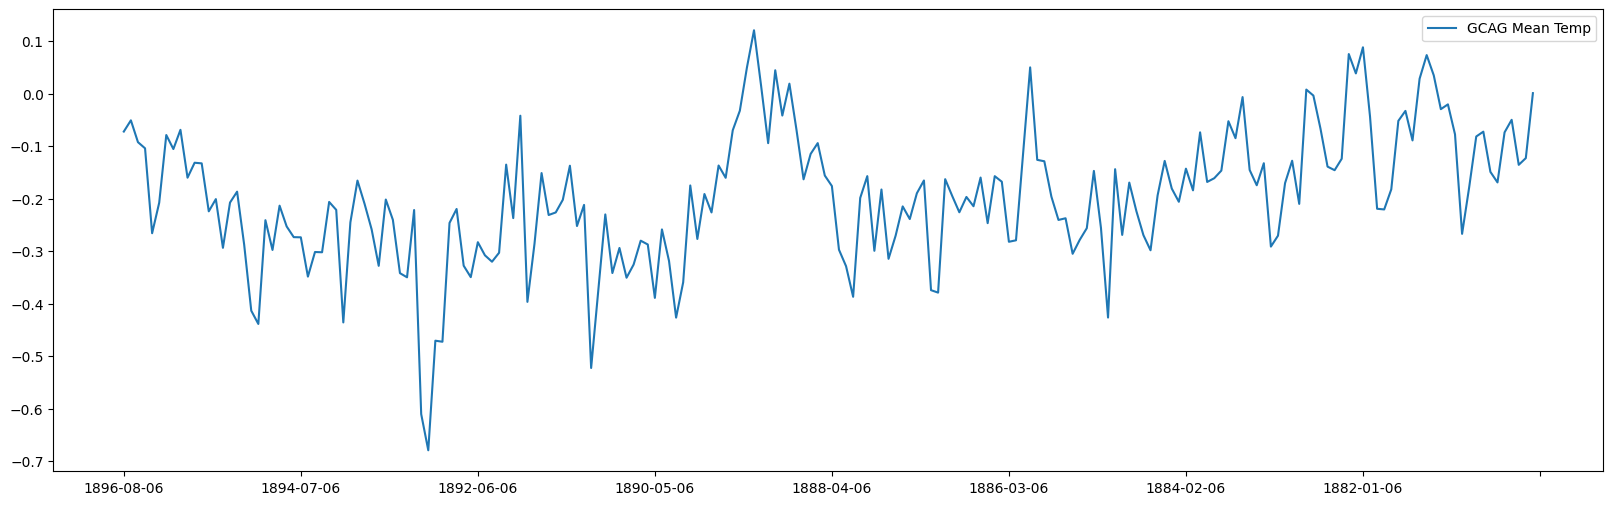

In [3]:
#Like the smoothing models, ARIMA models expects univariate data
#We also get the last 200 values,because fitting ARIMA models can be time consuming
#Feel free to try out with larger data
df = df[["GCAG Mean Temp"]][-200:].copy()
#Plot to visualize the time series data
df.plot(figsize=(20,6))
plt.show()

### ARIMA models

In [4]:
#Import the arima module from chronokit
from chronokit import arima

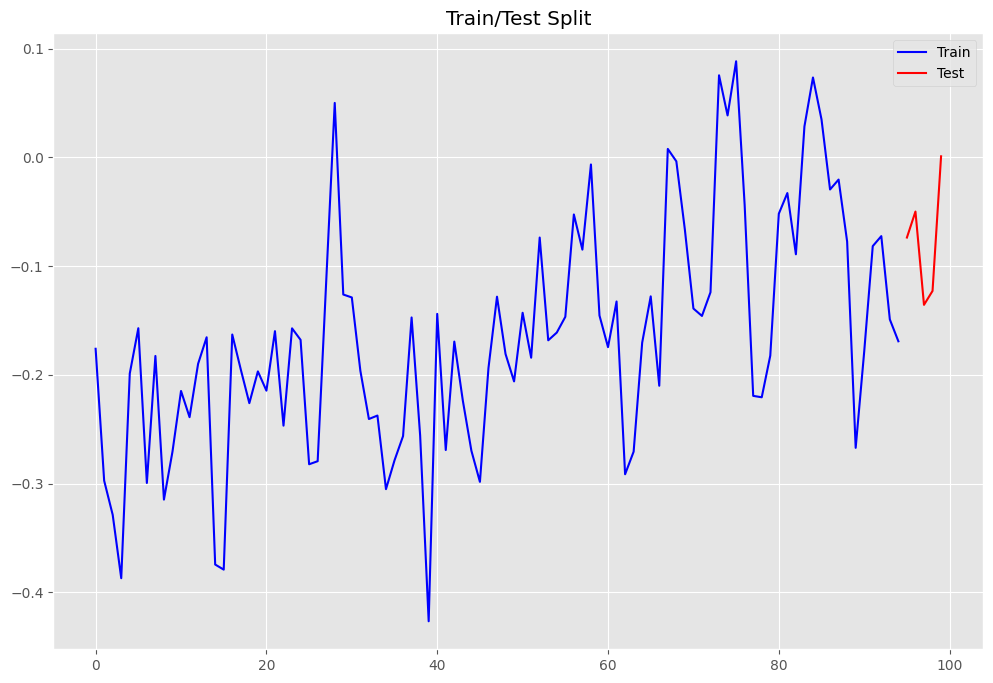

In [5]:
#Before fitting the models, split the data into training and testing;
#We will take the last 5 months of data to test the results of the models
df_train = df.iloc[:-5]
df_test = df.iloc[-5:]

#Plot the data by calling plot_train_test_split() function from chronokit.utils module
from chronokit.utils import plot_train_test_split
#Take a smaller part of the training data to visualize the test data better
plot_train_test_split(train_data=df_train[-95:], test_data=df_test, colors=["blue", "red"], style="ggplot", title="Train/Test Split")

In [6]:
#Initialize the ARIMA model
#Provide the order as p=1, d=1, q=1.
#By providing d=1, the ARIMA model will difference the data to estimate the parameters
arima_model = arima.ARIMA(data=df, p=1, d=1, q=1)

In [7]:
#Fit the model to the training data
arima_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
fc = arima_model.predict(h=5)

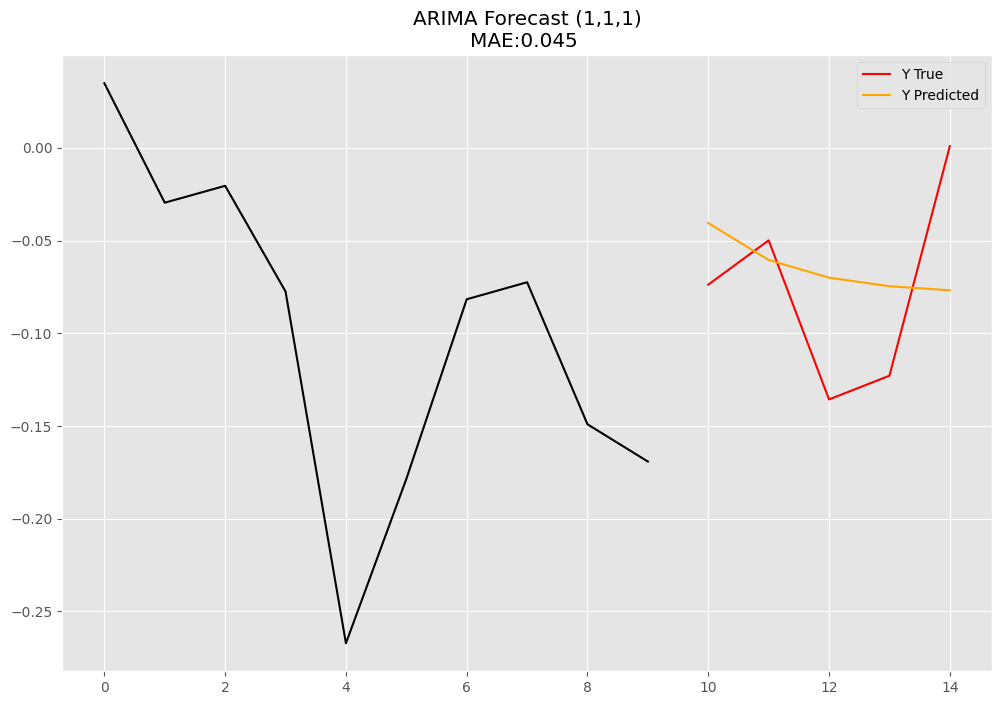

In [8]:
#Visualize the results by calling plot_predictions() from chronokit.utils module
from chronokit.utils import plot_predictions

#Provide the last 10 months of training data as pre_vals for a better visuals
#Provide metrics argument(as a list) to see the resulting metrics on the title
plot_predictions(y_true=df_test, y_pred=fc, pre_vals=df_train[-10:], colors=["red", "orange"], title="ARIMA Forecast (1,1,1)", metrics=["mae"])

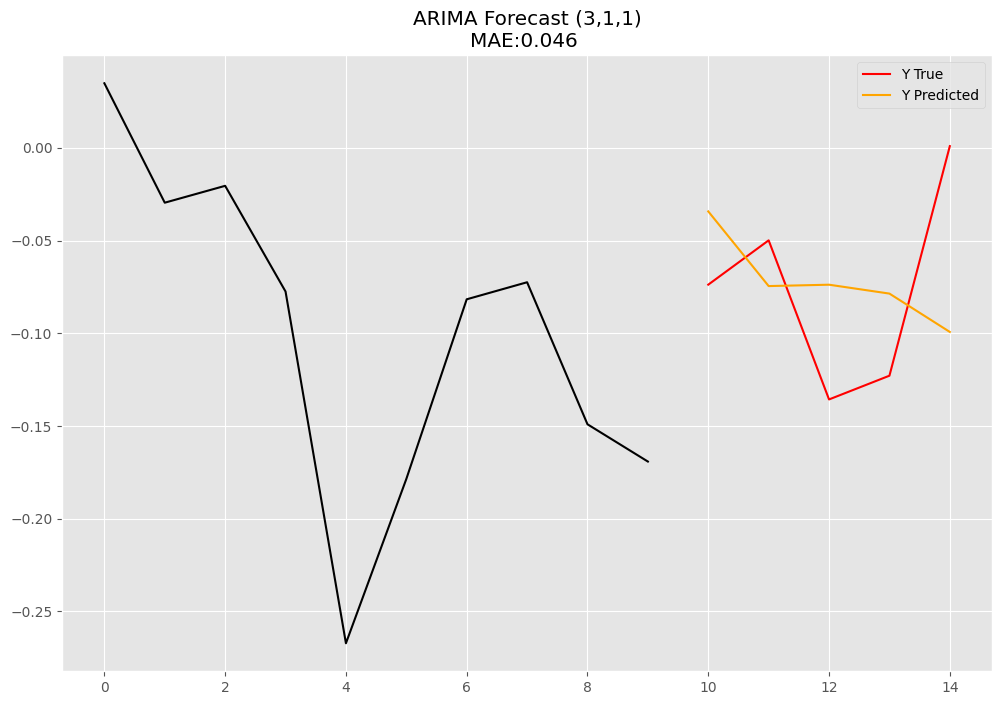

In [9]:
#Let's try to increase the order to (3,1,3) to see if we can get better results
arima_model = arima.ARIMA(data=df, p=3, d=1, q=3)

#Fit the model to the training data
arima_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
fc = arima_model.predict(h=5)

#The Mean Absolute Error is nearly the same, however they generated different forecasts
plot_predictions(y_true=df_test, y_pred=fc, pre_vals=df_train[-10:], colors=["red", "orange"], title="ARIMA Forecast (3,1,1)", metrics=["mae"])